# Source finding

## 1. Initialisation

In [1]:
%matplotlib ipympl
from matplotlib import pyplot as plt
from matplotlib import colors
import numpy as np
from time import time
from scipy import stats
import importlib
import scripts
importlib.reload(scripts)

> DEBUG: all scripts have been reloaded
> DEBUG: all scripts have been reloaded


<module 'scripts' from '/home/yago/public/git/paranoya/image-processing/scripts/__init__.py'>

## 2. Read data

In [2]:
importlib.reload(scripts.read_data)
object_name, data, wcs = scripts.read_data.run(21, (0, 0, 0))

Read dataset 21: "CIG 335" (1000, 1000) (0.0472 s)


## 3. Sort data

In [3]:
importlib.reload(scripts.sort_data)
argsorted_data, n_valid = scripts.sort_data.run(data.ravel())

Sorted 1000000 finite measurements in ascending order (0.122 s)


## 4. Hierarchical Overdensity Tree (HOT)

In [4]:
importlib.reload(scripts.HOT)
sorted_strides = np.hstack([np.sort(data.strides)//data.itemsize, data.size]) # DIRTY HACK when testig particles at the boundary
t0 = time()
label, catalog = scripts.HOT.run(data, argsorted_data, sorted_strides)
print(f'     {time()-t0:.3g} seconds')

HOT: 160225 overdensities found, 1000000 "pixels" (100%), 1 independent regions
     3.51 seconds


In [5]:
parent = catalog[0]
area = catalog[1]
test_stat = catalog[2]
#max_test_stat = catalog[3]

## 5. Reliability

1245 sources (0.0518 s)


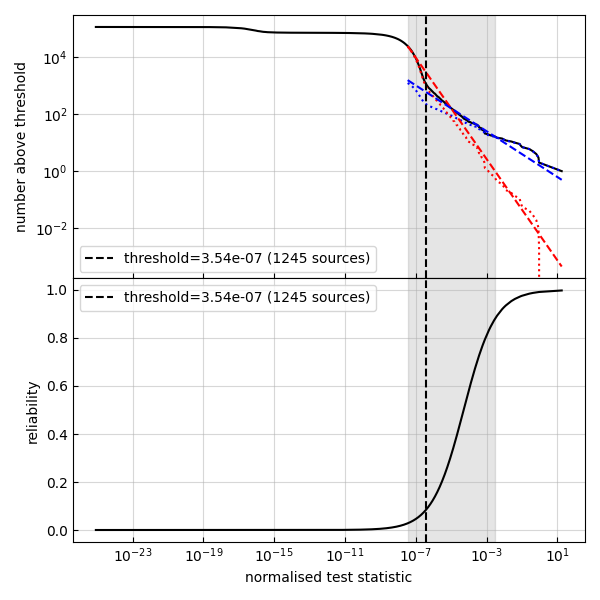

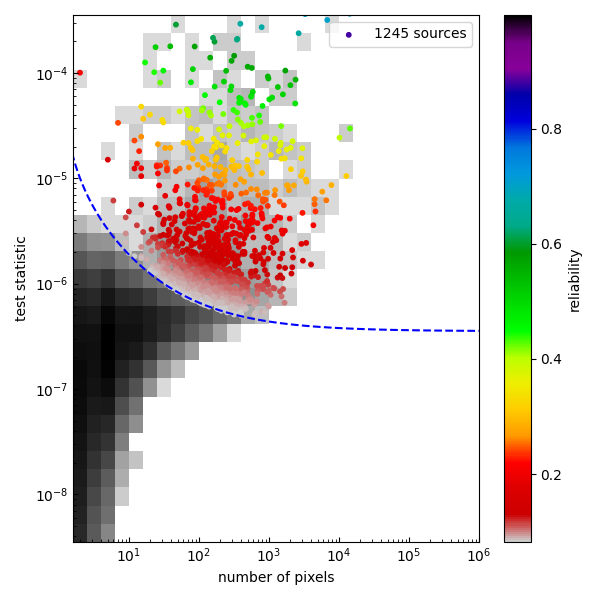

In [6]:
importlib.reload(scripts.reliability)
reliability = scripts.reliability.run(test_stat, area, plots=True)

In [7]:
true_overdensity = reliability > 0
n_sources = np.count_nonzero(true_overdensity)
print(f'{n_sources} potential sources found')

1245 potential sources found


## 6. Clean-up

In [8]:
importlib.reload(scripts.cleanup)
label, old_label = scripts.cleanup.run(label, parent, area, true_overdensity, plots=True)

Prune HOT...
 158981 yet to go
 84963 yet to go
 23612 yet to go
 2817 yet to go
 127 yet to go
 3 yet to go
 1 yet to go
... and rename labels
1246 objects, 0.0313 seconds


## 7. Explore results

### Definitions

In [9]:
plots = True
data_dimensionality = sorted_strides.size-1
#p0, p16, p50, p100 = np.nanpercentile(data, [0, 16, 50, 100])
#colour_scale = colors.SymLogNorm(vmin=p50-3*(p50-p16), linthresh= p50+3*(p50-p16), vmax=p100)
#data_min = data.ravel()[argsorted_data[0]]
#pivot = np.percentile(data[data > 0], 1)
scale_min = data.ravel()[argsorted_data[int(argsorted_data.size*.01)]]
pivot = data.ravel()[argsorted_data[int(argsorted_data.size*.5)]]  # median
scale_max = data.ravel()[argsorted_data[int(argsorted_data.size*.99)]]
colour_scale = colors.SymLogNorm(vmin=scale_min, linthresh=2*pivot-scale_min, vmax=scale_max)

In [10]:
my_cmap = np.vstack([np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.argsort(np.random.random(n_sources))/n_sources, np.ones(n_sources)]).T
final_cmap = colors.ListedColormap(my_cmap)

In [11]:
def show_segmentation(intensity, labels, intensity_scale):
    fig_name = 'segmentation'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 4))
    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(object_name)
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title(f'segmentation ({n_sources} objects)')
    im = ax.imshow(
        labels,
        interpolation='nearest', origin='lower',
        cmap=final_cmap,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title(f'Reliability')
    im = ax.imshow(
        reliability[old_label[labels]],
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

### Individual objects

> DEBUG: [193 274]-[395 480] / [294 377]: [202 206] ((1000, 1000))
> DEBUG: [143 223]-[345 429]


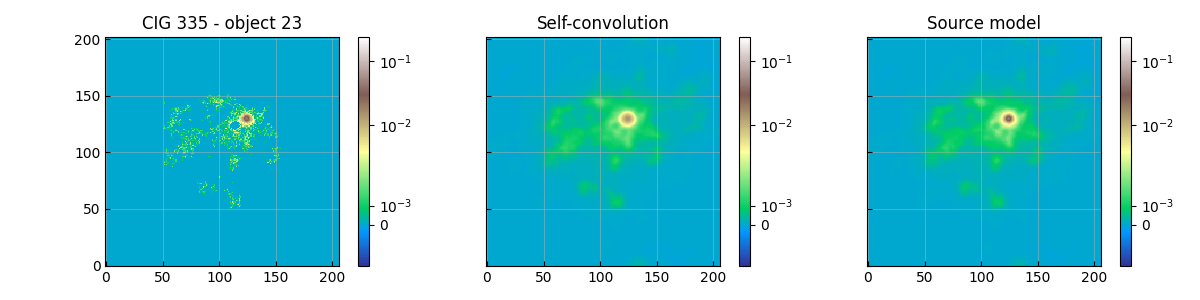

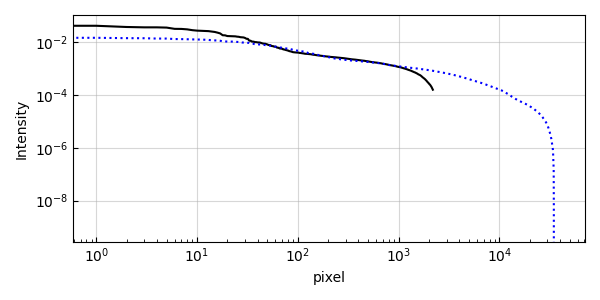

In [130]:
def explore_object_2D(object_label, data, labels, intensity_scale):
    target = np.where(label == object_label)
    target_min = np.nanmin(data[target])
    n_target = target[0].size
    index_min = np.min(target, axis=1).astype(int)
    L = np.minimum(data.shape, 2*(np.max(target, axis=1).astype(int) - index_min))
    print(f'> DEBUG: {index_min}-{index_min+L} / {np.max(target, axis=1).astype(int)}: {L} ({data.shape})')
    index_min = np.clip(index_min-L//4, a_min=0, a_max=data.shape-L)
    print(f'> DEBUG: {index_min}-{index_min+L}')

    intensity = np.zeros(L)
    shifted_target = np.ravel_multi_index(target-index_min[:, np.newaxis], intensity.shape)
    intensity.flat[shifted_target] = data[target]
    decreasing_intensity = np.argsort(intensity.flat[shifted_target])[::-1]

    transform = np.fft.rfftn(intensity)
    convolution = np.fft.irfftn(transform*np.absolute(transform))
    decreasing_model = np.argsort(convolution.flat)[::-1]
    convolution *= np.sum(intensity) / np.sum(convolution.flat[decreasing_model[:n_target]])

    model = convolution.copy()
    #model.flat[decreasing_model[:n_target]] = intensity.flat[shifted_target][decreasing_intensity]
    #model.flat[decreasing_model[:n_target]] = np.maximum(model.flat[decreasing_model[:n_target]], intensity.flat[shifted_target][decreasing_intensity])
    convolution_weight = np.arange(n_target)/n_target
    model.flat[decreasing_model[:n_target]] = (
        convolution_weight * model.flat[decreasing_model[:n_target]] + (1-convolution_weight) * intensity.flat[shifted_target][decreasing_intensity])
    

    fig_name = 'explore_object'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(12, 3))    
    axes = fig.subplots(nrows=1, ncols=3, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.set_title(f'{object_name} - object {object_label}')
    im = ax.imshow(
        intensity,
        interpolation='nearest', origin='lower',
        #cmap='ocean',
        #cmap='nipy_spectral',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 1]
    ax.set_title('Self-convolution')
    im = ax.imshow(
        convolution,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    ax = axes[0, 2]
    ax.set_title('Source model')
    im = ax.imshow(
        model,
        interpolation='nearest', origin='lower',
        cmap='terrain',
        norm = intensity_scale,
        )
    cb = fig.colorbar(im, ax=ax)

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()

    
    fig_name = 'object_intensity_profile'
    plt.close(fig_name)
    fig = plt.figure(fig_name, figsize=(6, 3))
    axes = fig.subplots(nrows=1, ncols=1, squeeze=False,
                        sharex=True, sharey=True,
                        gridspec_kw={'hspace': 0, 'wspace': 0})

    ax = axes[0, 0]
    ax.plot(intensity.flat[shifted_target][decreasing_intensity], 'k-')
    ax.plot(convolution.ravel()[decreasing_model], 'b:')
    ax.set_ylabel('Intensity')
    ax.set_yscale('log')
    ax.set_xlabel('pixel')
    ax.set_xscale('log')

    for ax in axes.flatten():
        ax.tick_params(which='both', direction='in')
        ax.grid(alpha=.5)
    fig.set_tight_layout(True)
    plt.show()


explore_object_2D(23, data, label, colour_scale)

> DEBUG: [181 268]-[459 682] ((1000, 1000))
> DEBUG: [42 61]-[320 475]


In [59]:
target-index_min[:, np.newaxis], L

(array([[139, 140, 140, ..., 276, 277, 278],
        [270, 269, 270, ..., 382, 371, 360]]),
 array([278, 414]))

In [38]:
data[(target-index_min[:, np.newaxis]).astype(int)]


array([[[-1.0373406e-03, -1.3800671e-03, -9.1175294e-05, ...,
          1.4482698e-04,  6.9153425e-04,  2.3591035e-04],
        [-1.8058774e-03, -9.6659450e-04,  1.6233857e-03, ...,
          2.3881327e-03,  3.2670593e-03,  2.1454960e-03],
        [-1.8058774e-03, -9.6659450e-04,  1.6233857e-03, ...,
          2.3881327e-03,  3.2670593e-03,  2.1454960e-03],
        ...,
        [-1.4208395e-04,  5.7275273e-04,  2.7041412e-03, ...,
          4.2375689e-04, -2.6572699e-04,  3.6865723e-04],
        [ 1.7788877e-03,  5.8189523e-04, -1.1186191e-03, ...,
          2.1684053e-03,  2.2012899e-03, -1.7313547e-03],
        [-1.8169433e-04,  1.0244045e-03,  2.5723860e-04, ...,
          5.4771896e-04, -2.5872927e-04, -2.7097971e-03]],

       [[ 1.8916894e-03,  1.7683355e-03,  2.3537891e-03, ...,
          7.3648145e-04, -5.2768504e-05,  1.7547938e-03],
        [ 2.0981848e-03,  1.2514890e-03,  2.8050756e-03, ...,
          1.0146394e-03, -1.8362029e-04,  1.6007576e-03],
        [ 1.8916894e-03, 

### Segmentation

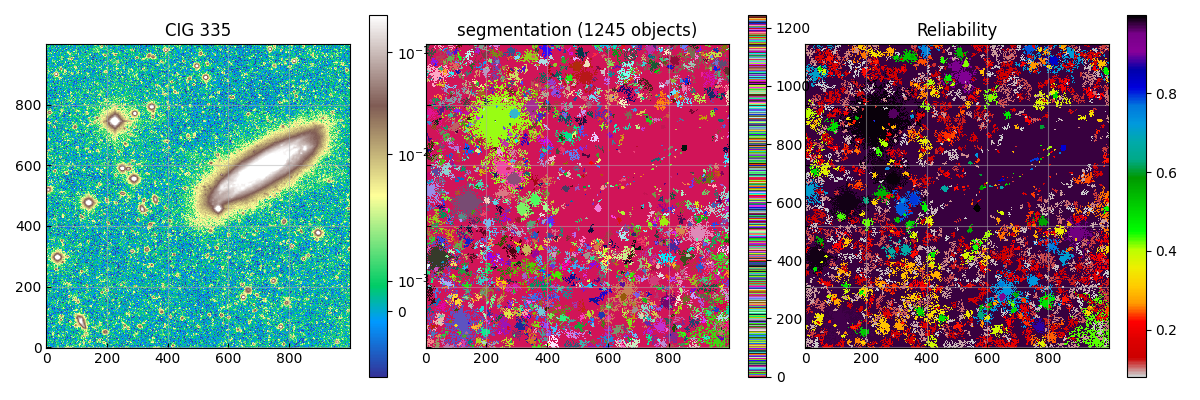

In [126]:
if plots and data_dimensionality == 2:
    show_segmentation(data, label, colour_scale)

elif plots and data_dimensionality == 3:
    intensity = np.nanmean(data**2, axis=0)
    p16, p50 = np.nanpercentile(intensity, [16, 50])
    intensity = (intensity-p50)/(p50-p16)
    #intensity_scale = colors.SymLogNorm(vmin=-3, linthresh=1, vmax=10)
    intensity_scale = colors.Normalize(vmin=-3, vmax=3)
    show_segmentation(intensity, np.nanmax(label, axis=0), intensity_scale)


In [ ]:
'''
if plots and data_dimensionality == 3:

    mode = 0
    
    #boundary = np.zeros_like(max_map)
    #boundary[:, :-1][max_map[:, :-1] != max_map[:, 1:]] = 1
    #boundary[:-1, :][max_map[:-1, :] != max_map[1:, :]] = 1
    plt.close('filtered')
    fig = plt.figure('filtered', figsize=(8, 8))
    ax = fig.subplots(nrows=2, ncols=2, squeeze=False,
                      sharex=True, sharey=True,
                      gridspec_kw={'bottom': .01, 'left': .1, 'top': .99, 'right': .92,
                                   'hspace': .01, 'wspace': .1},
                      subplot_kw={'projection': wcs},
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
    #fig.set_tight_layout(True)

    ax[0, 0].set_title('Input data (max)')
    im = ax[0, 0].imshow(
        np.nanmax(data, axis=0),
        interpolation='nearest', origin='lower', cmap='terrain',
        norm = colour_scale
    )
    #ax[0, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 0].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[1, 1].contour(boundary, levels=[.5], colors='k', linewidths=0.1)
    #ax[0, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 0].contour(max_map, levels=np.arange(n_sources)+.5, colors='k', linewidths=0.1)
    #ax[1, 1].contour(max_map, levels=np.arange(n_sources)+.5, colors='w', linewidths=0.1)
    cb = fig.colorbar(im, ax=ax[0, 0])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[0, 1].set_title('Input data (rms)')
    im = ax[0, 1].imshow(
        #(np.sqrt(np.nanmean((data-mode)**2, axis=0)) + np.nanmax(data, axis=0))/2,
        np.nansum(data, axis=0)/np.sqrt(np.nanmean(data**2, axis=0)),
        vmin=0,
        interpolation='nearest', origin='lower', cmap='terrain',
        #norm = colors.SymLogNorm(vmin=-delta_th, linthresh=3*delta_th, vmax=np.max(data-mode)),
        #vmin=-delta/100, vmax=3*delta/10,
        #norm = colour_scale,
    )
    #ax[0, 1].contour(max_map, levels=[0.5])
    cb = fig.colorbar(im, ax=ax[0, 1])
    cb.ax.axhline(0, c='k', ls=':')
    #cb.ax.axhline(data.threshold-mode, c='k', ls='--')
    
    ax[1, 0].set_title(f'Final selection map (max)\n({n_sources} objects)')
    im = ax[1, 0].imshow(
        max_map,
        interpolation='nearest', origin='lower',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    cb = fig.colorbar(im, ax=ax[1, 0])

    #ax[1, 1].set_title('<lbl^2> / <lbl>')
    im = ax[1, 1].imshow(
        reliability[old_label[max_map]],
        #np.nansum(final_labels**2, axis=0) / np.nansum(final_labels, axis=0),
        interpolation='nearest', origin='lower',
        cmap='nipy_spectral_r',
        #vmin=n_reliable/(n_sources+1), vmax=reliability_threshold,
        #cmap='rainbow_r',
        #vmin=1, vmax=n_final_labels-1,
        )
    cb = fig.colorbar(im, ax=ax[1, 1])
'''

In [ ]:
if plots and data_dimensionality == 3:
    x_range = np.round(plt.figure('segmentation').get_axes()[0].get_xlim()).astype(int)
    y_range = np.round(plt.figure('segmentation').get_axes()[0].get_ylim()).astype(int)
    section = (data[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]-mode)
    section_lables = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    norm = (y_range[1] - y_range[0]) * (x_range[1] - x_range[0])
    section_labels = label[:, y_range[0]:y_range[1], x_range[0]:x_range[1]]
    unique_section_labels = np.unique(section_labels)

    vertical_slit = np.max(section_labels, axis=2).T
    horizontal_slit = np.max(section_labels, axis=1).T

    plt.close('spectrum')
    fig = plt.figure('spectrum', figsize=(8, 8))
    ax = fig.subplots(nrows=5, ncols=1, squeeze=False,
                      sharex=True, sharey=False,
                      gridspec_kw={'hspace': 0, 'wspace': 0}
                     )
    for axis in ax.flatten():
        axis.tick_params(which='both', direction='in')
        axis.grid(alpha=.5)
        
    fig.set_tight_layout(True)

    
    ax[0, 0].set_title(f'Mean spectra for x in {x_range}, y in {y_range}\n({unique_section_labels.size} objects)')
    im = ax[0, 0].imshow(
        vertical_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[0, 0].set_aspect('auto')
    ax[0, 0].set_ylabel(r'$\Delta y$')


    im = ax[1, 0].imshow(np.nanmean(section, axis=2).T,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #norm=colour_scale,
                        )
    #ax[1, 0].contour(vertical_slit, levels=0)
    ax[1, 0].set_aspect('auto')
    ax[1, 0].set_ylabel(r'$\Delta y$')


    ax[2, 0].plot(np.nanmean(section, axis=(1, 2)), 'k-', lw=3)
    ax[2, 0].set_ylabel('spectrum')
    '''
    '''
    for lbl in unique_section_labels[:10]:  # Dirty fix
        mask = np.zeros_like(section)
        mask[section_labels == lbl] = 1
        if lbl == 0:
            ls = ':'
        else:
            ls = '-'
        ax[2, 0].plot(np.nansum(section*mask, axis=(1, 2))/norm, alpha=.5, ls=ls, label=f'{lbl}')
    mean_error = 1/np.sqrt(section.shape[1]*section.shape[2])
    #ax[2, 0].axhline(delta_th*mean_error*bg_std, c='k', ls=':')
    #ax[2, 0].axhline(-delta_th*mean_error*bg_std, c='k', ls=':')
    ax[2, 0].legend()
    
    
    im = ax[3, 0].imshow(np.nanmean(section, axis=1).T,
        #(np.nanmax(section, axis=1) + np.sqrt(np.nanmean(section**2, axis=1))).T/2,
                         interpolation='nearest', origin='lower', cmap='terrain',
                         #vmin=0,
                         norm=colour_scale,
                        )
    #ax[3, 0].contour(horizontal_slit, levels=0)
    ax[3, 0].set_aspect('auto')
    ax[3, 0].set_ylabel(r'$\Delta x$')

    ax[4, 0].set_ylabel(r'$\Delta x$')
    im = ax[4, 0].imshow(
        horizontal_slit,
        interpolation='nearest', origin='lower',
        #vmin=0, vmax=n_final_labels-1, cmap='rainbow',
        cmap=final_cmap, vmin=-0.5, vmax=n_sources-0.5,
        )
    ax[4, 0].set_aspect('auto')
    ax[4, 0].set_ylabel(r'$\Delta x$')

    ax[-1, 0].set_xlabel('frequency / wavelength channel')


## Save FITS file

In [ ]:
hdu_out = fits.PrimaryHDU(final_labels)
hdu_out.writeto('output/HOT_labels.fits', overwrite=True)
'''
'''


In [ ]:
if data_dimensionality == 3:
    hdu_out = fits.PrimaryHDU(np.sum(final_labels, axis=0) / (np.count_nonzero(final_labels, axis=0) + 1e-30))
    hdu_out.writeto('output/HOT_mask.fits', overwrite=True)
'''
'''
